<a href="https://colab.research.google.com/github/sudhirk999/StyleTransfer/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NEURAL STYLE TRANSFER**

**Neural style transfer consists of applying the style of a reference image to a target
image while conserving the content of the target image**

The key notion behind implementing style transfer is the same idea that’s central
to all deep-learning algorithms:
You define a loss function to specify what you want to achieve, and you minimize this loss. 
The things we want to achieve during this is conserving the content of the original image while adopting the style of the reference image. 

If we were able to mathematically define content and style, then an appropriate loss func-
tion to minimize would be the following ---

**loss = distance(style(reference_image) - style(generated_image)) +
distance(content(original_image) - content(generated_image))**


* ***distance*** is a norm function such as the L2 norm, 
* ***content*** is a **function** that
takes an image and computes a representation of its content, 
* ***style*** is a **function** that takes an image and computes a representation of its style.

Minimizing this loss causes ***style(generated_image)*** to be close to ***style(reference_image)*** , and
***content(generated_image)*** is close to ***content(reference_image)*** , thus achieving
style transfer as we defined it.

In [0]:
import keras.backend as K
from keras.applications import vgg19
from keras.preprocessing.image import load_img, img_to_array

import numpy as np
import time

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

# Content Loss

activations from earlier layers in a network contain local informa-
tion about the image, whereas activations from higher layers contain increasingly global,
abstract information.
If you have a CNN that recognizes faces, maybe it starts with borders first, and learns higher representations like noses, eyes, and mouths in subsequent layers. The final CNN layers are what actually recognize faces.

Therefore, you’d expect the content of an image, which is more global and
abstract, to be captured by the representations of the upper layers in a convnet.
A good candidate for content loss is thus the L2 norm between the activations of
an upper layer in a pretrained convnet, computed over the target image, and the acti-
vations of the same layer computed over the generated image.

\begin{equation*}
 \mathcal{L}_{content} (\vec{p},\vec{x},l)=\frac{1}{2} \sum_{i,j}(F^l_{ij}-P^l_{ij})^2.
\end{equation*}


*  We have a function that we call content loss
    That function takes in 3 parameters
        p -> the content target
        x -> the generated image
        l -> the layer in question
* We construct 2 feature representations with this information
        F -> the feature representation of the generated image
            In English, this is what the layer outputs to us when we run our image through the network
        P -> the feature representation of the content target
* We take the element-wise difference (subtract each index value by the matching one between the two matrices)
* We take the element-wise square of this (square each index value), sum all those values together and divide by 2 



In [0]:
def content_loss(base, combination_features):
    return K.sum(K.square(combination_features - base))

# Style Loss

The style loss uses multiple layers of a convnet: you try to capture the appearance of the style-
reference image at all spatial scales extracted by the convnet, not just a single scale

It use the ***Gram matrix*** of a layer’s activations: the inner
product of the feature maps of a given layer. This inner product can be understood as
representing a map of the correlations between the layer’s features. These feature cor-
relations capture the statistics of the patterns of a particular spatial scale, which empir-
ically correspond to the appearance of the textures found at this scale.

Hence, the style loss aims to preserve similar internal correlations within the activa-
tions of different layers, across the style-reference image and the generated image.


The computation for that is defined as this: 

\begin{equation*}
 G^l_{ij}=\sum_k F^l_{ik}F^l_{jk}.
\end{equation*}

This is simply the dot product between the feature matrix and its transpose. Not too bad.

Next the original paper gives us these two equations to define the loss:

\begin{equation*}
 E_l=\frac{1}{4N_l^2 M_l^2} \sum_{i,j}(G^l_{ij}-A^l_{ij})^2
\end{equation*}

\begin{equation*}
 \mathcal{L}_{style}(\vec{a},\vec{x})=\sum_{l=0}^L w_l E_l,
\end{equation*}

We'll come back to the the weighting aspect later on, but the first equation is essentially taking an L2 norm (a Frobenius norm).

* Subtract element-wise the gram matrices
* Square element-wise
* Sum them together
* Multiply by our factor 1/(4 (color channels)^2 (total pixel values)^2)

And then we multiply by weighting based on layers, but we'll return to that in a bit. We'll actually use that first equation to define our style loss.

** Note that the img_channels and img_size are global parameters that we'll actually define later**

In [0]:
def gram_matrix(x):
  
    # Permute the matrix to calculate proper covariance
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    
    gram = K.dot(features, K.transpose(features))
    
    return gram
  
  
def style_loss(style, combination):
  
    # Get the gram matrices
    S = gram_matrix(style)
    C = gram_matrix(combination)
    
    img_channels = 3
    
    img_size = img_height * img_width
    
    return K.sum(K.square(S - C)) / (4. * (img_channels ** 2) * (img_size ** 2))

We add a third loss: the ***total variation loss***, which operates
on the pixels of the generated combination image. It encourages spatial continuity in
the generated image, thus avoiding overly pixelated results. You can interpret it as a
regularization loss.

 It encourages **smoothness ** and **discourages** noise. This leads to **cleaner images** that aren't as **pixelated**. No fancy math here, just shifting some pixel values

In [0]:
def total_variation_loss(generated_matrix):
    
    a = K.square(generated_matrix[:, :img_height-1, :img_width-1, :] - generated_matrix[:, 1:, :img_width-1, :])
    b = K.square(generated_matrix[:, :img_height-1, :img_width-1, :] - generated_matrix[:, :img_height-1, 1:, :])

    return K.sum(K.pow(a + b, 1.25))

This is the general process:

1. Set up a network that computes VGG19 layer activations for the style-reference
image, the target image, and the generated image at the same time.
2. Use the layer activations computed over these three images to define the loss
function described earlier, which you’ll minimize in order to achieve style
transfer.
3. Set up a gradient-descent process to minimize this loss function.

In [0]:
# Path to the image you want to transform
target_image_path = 'female_knight.jpg'

# Path to the style image
style_reference_image_path = 'wave.jpg'

# Dimensions of the generated picture
width, height = load_img(target_image_path).size

img_height = 400

img_width = int(width * img_height / height)

In [0]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [0]:
def deprocess_image(x):
  
    # Zero-centering by removing the mean pixel value from ImageNet. 
    # This reverses a transformation done by vgg19.preprocess_input.
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # Converts images from 'BGR' to 'RGB'.This is also part of the reversal of
    # vgg19.preprocess_input
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [24]:
target_image = K.constant(preprocess_image(target_image_path))

style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# Placeholder that will contain the generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# Combines the three images in a single batch
input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

# Builds the VGG19 network with the batch of three images as input. The model will be loaded with pretrained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

print('Model loaded.')

Model loaded.


In [25]:
# Dictionary that maps layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Layer used for content loss
content_layer = 'block5_conv2'

# Layers used for style loss
style_layers = ['block1_conv1','block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# We’ll define the loss by adding all components to this scalar variable.
loss = K.variable(0.)                                        
layer_features = outputs_dict[content_layer]                   # Adds the content loss

target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(target_image_features, combination_features)

# Adds a style loss component for each target layer
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
    
# Adds the total variation loss   
loss += total_variation_weight * total_variation_loss(combination_image)

We’ll set up the gradient-descent process. In the original paper,
optimization is performed using the **L-BFGS algorithm**, so that’s what you’ll use here. 
The **L-BFGS algorithm** comes packaged with SciPy, but there are two slight limitations with the SciPy implementation:

* It requires that you pass the value of the loss function and the value of the gra-
dients as two separate functions.
* It can only be applied to flat vectors, whereas you have a 3D image array.

It would be inefficient to compute the value of the loss function and the value of the
gradients independently, because doing so would lead to a lot of redundant computa-
tion between the two; the process would be almost twice as slow as computing them
jointly. To bypass this, you’ll set up a Python class named Evaluator that computes
both the loss value and the gradients value at once, returns the loss value when called
the first time, and caches the gradients for the next call.

In [0]:
# Gets the gradients of the generated image with regard to the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

# This class wraps fetch_loss_and_grads in a way that lets you retrieve the losses and gradients via two separate method calls, which is
# required by the SciPy optimizer you'll use.

class Evaluator(object):
  
    def __init__(self):
      self.loss_value = None
      self.grads_values = None
      
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
      
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [37]:
evaluator = Evaluator()

result_prefix = 'my_result'
iterations = 20

# This is the initial state: the target image.
x = preprocess_image(target_image_path)

# You flatten the image because scipy.optimize.fmin_l_bfgs_b can only process flat vectors.
x = x.flatten()

for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  
  # Runs L-BFGS optimization over the pixels of the generated image to minimize the neural style loss. Note that you have to pass the function that
  # computes the loss and the function that computes the gradients as two separate arguments.
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
  print('Current loss value:', min_val) 
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  
  end_time = time.time()
  print('Iteration %d completed in %ds' % (i, end_time - start_time))
  
# Saves the current generated image.
imsave('final_img.png', img)

Start of iteration 0
Current loss value: 1078160500.0
Iteration 0 completed in 8s
Start of iteration 1
Current loss value: 390018560.0
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 224869890.0
Iteration 2 completed in 8s
Start of iteration 3
Current loss value: 161707600.0
Iteration 3 completed in 8s
Start of iteration 4
Current loss value: 124593860.0
Iteration 4 completed in 8s
Start of iteration 5
Current loss value: 105425990.0
Iteration 5 completed in 8s
Start of iteration 6
Current loss value: 92902630.0
Iteration 6 completed in 8s
Start of iteration 7
Current loss value: 85121304.0
Iteration 7 completed in 9s
Start of iteration 8
Current loss value: 78338040.0
Iteration 8 completed in 8s
Start of iteration 9
Current loss value: 73736460.0
Iteration 9 completed in 8s
Start of iteration 10
Current loss value: 69251730.0
Iteration 10 completed in 8s
Start of iteration 11
Current loss value: 65929052.0
Iteration 11 completed in 8s
Start of iteration 12
Current

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [33]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


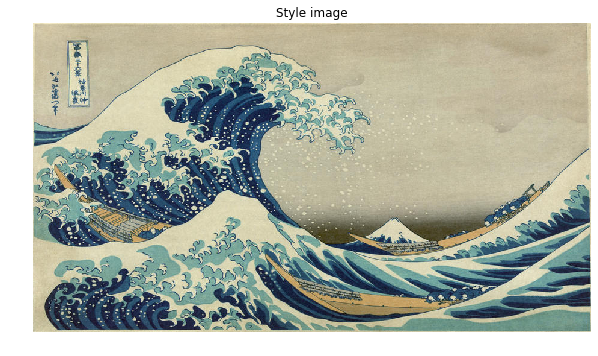

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
img = plt.imread('wave.jpg')
plt.axis('off')
plt.title('Style image')
plt.imshow(img)

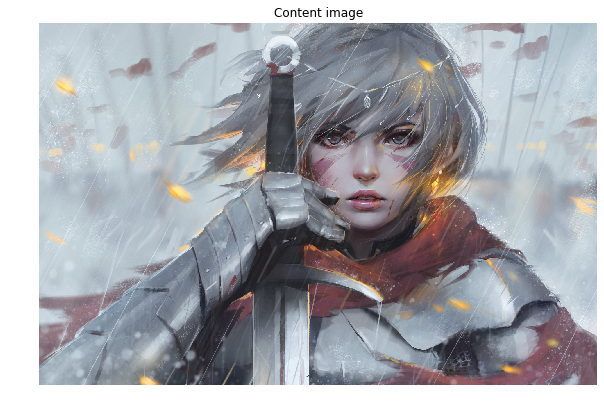

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
img = plt.imread('female_knight.jpg')
plt.axis('off')
plt.title('Content image')
plt.imshow(img)

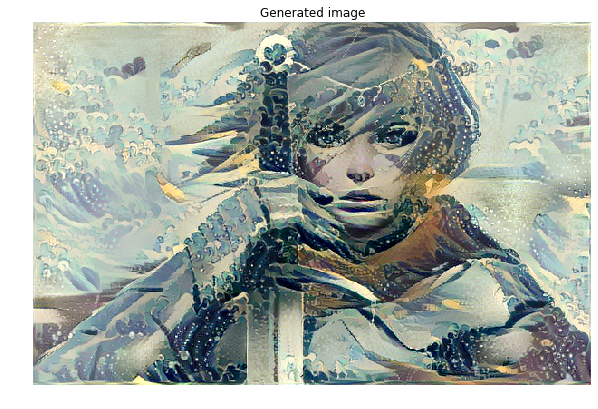

In [38]:
fig = plt.figure(figsize=(10, 10))
img = plt.imread("final_img.png")
plt.axis('off')
plt.title('Generated image')
plt.imshow(img)